<a href="https://colab.research.google.com/github/Did-Mas/RadonTransform/blob/main/RadonTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformata Radona
## Systemy Dedykowane w Układach Programowalnych
Autorzy: Kacper Gubała, Dawid Maślanka

## Zarys teoretyczny
  Poniżej zawarto krótkie opisy operacji matematycznych zawartych w projekcie.

### Transforamta Radona
  W matematyce transformata Radona to przekształcenie całkowe, które przypisuje funkcji 𝑓 zdefiniowanej na płaszczyźnie nową funkcję 𝑅𝑓, zdefiniowaną na (dwuwymiarowej) przestrzeni prostych tej płaszczyzny. Wartość funkcji 𝑅𝑓 dla danej prostej jest równa całce liniowej funkcji 𝑓 wzdłuż tej prostej.

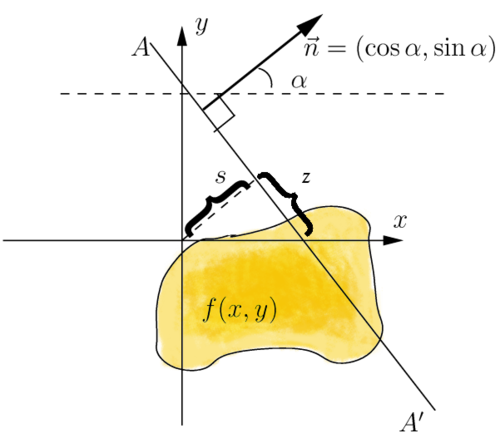

  *Transformata Radona. Przekształca funkcję 𝑓 z dziedziny (𝑥,𝑦) do funkcji 𝑅𝑓 w dziedzinie (𝛼,𝑠).*

  Transformata Radona znajduje szerokie zastosowanie w tomografii, czyli tworzeniu obrazu na podstawie danych projekcyjnych związanych ze skanami przekrojowymi obiektu.

  Jeśli funkcja 𝑓 reprezentuje nieznaną gęstość, to transformata Radona odpowiada danym projekcyjnym uzyskanym jako wynik skanowania tomograficznego. W związku z tym odwrotność transformaty Radona może zostać użyta do rekonstrukcji pierwotnej gęstości na podstawie danych projekcyjnych, co stanowi matematyczne podstawy rekonstrukcji tomograficznej, znanej również jako rekonstrukcja iteracyjna.

  Dane z transformaty Radona są często nazywane **sinogramem**, ponieważ transformata Radona punktowego źródła położonego poza środkiem układu współrzędnych ma postać sinusoidy. W konsekwencji transformata Radona wielu małych obiektów graficznie wygląda jak zbiór rozmytych fal sinusoidalnych o różnych amplitudach i fazach.




## Implementacja wysoko poziomowa



### Transformata Radona

In [106]:
from skimage.data import shepp_logan_phantom
from skimage.transform import rotate, iradon
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

(400, 400)


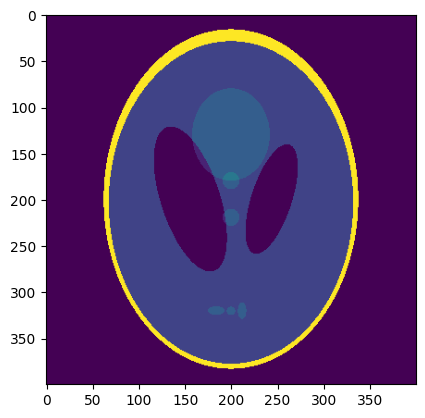

In [107]:
phantom_org = shepp_logan_phantom()
phantom = rotate(phantom_org, 90)
print(phantom.shape)
plt.imshow(phantom_org)

In [108]:
dAlpha = 1

alphas = np.arange(dAlpha, 180, dAlpha)
np.insert(alphas, 0, 0)
esses = np.linspace(-1, 1, phantom.shape[1])
dS = np.diff(esses)[0]

projections = np.zeros((phantom.shape[1], len(alphas)))
rotated_images = []

rotated_images.append(phantom)
res = np.sum(phantom, axis=1)
projections[:, 0]=res

for i, alpha in enumerate(alphas):
  rotated_phantom = rotate(phantom, alpha)
  rotated_images.append(rotated_phantom)

  res = np.sum(rotated_phantom, axis=1) * dS
  projections[:, i]=res

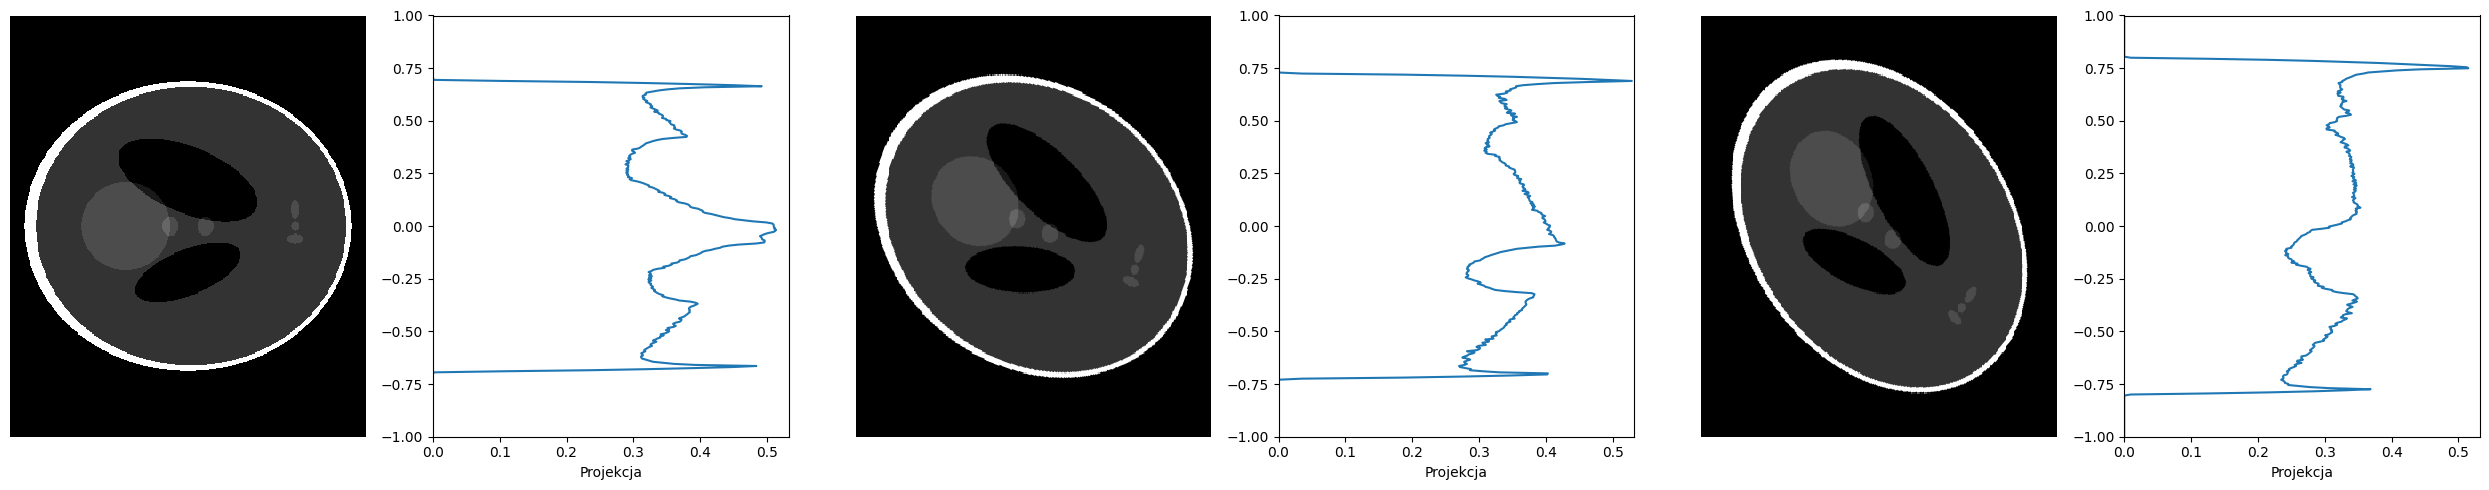

In [109]:
fig, axes = plt.subplots(1, 6, figsize=(25, 5))

angle_idxes = [0, 20, 40]

j=0
for i in range(0, len(axes), 2):
  angle_idx = angle_idxes[j]
  ax_im = axes[i]
  ax_proj = axes[i+1]

  ax_im.pcolormesh(rotated_images[angle_idx], cmap='gray')
  ax_im.axis('off')

  ax_proj.plot(projections[:, angle_idx], esses)
  ax_proj.set_xlim(0, projections.max())
  ax_proj.set_ylim(-1, 1)
  ax_proj.set_xlabel('Projekcja')
  j+=1

  plt.tight_layout()


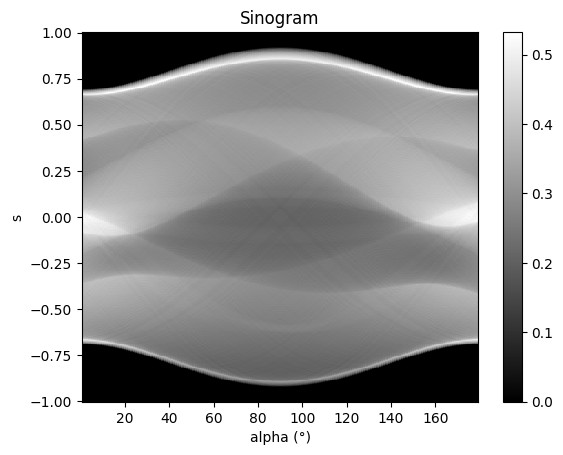

In [110]:
plt.pcolormesh(alphas, esses, projections, shading="auto", cmap='gray')
plt.xlabel("alpha (°)")
plt.ylabel("s")
plt.colorbar()
plt.title("Sinogram")
plt.show()

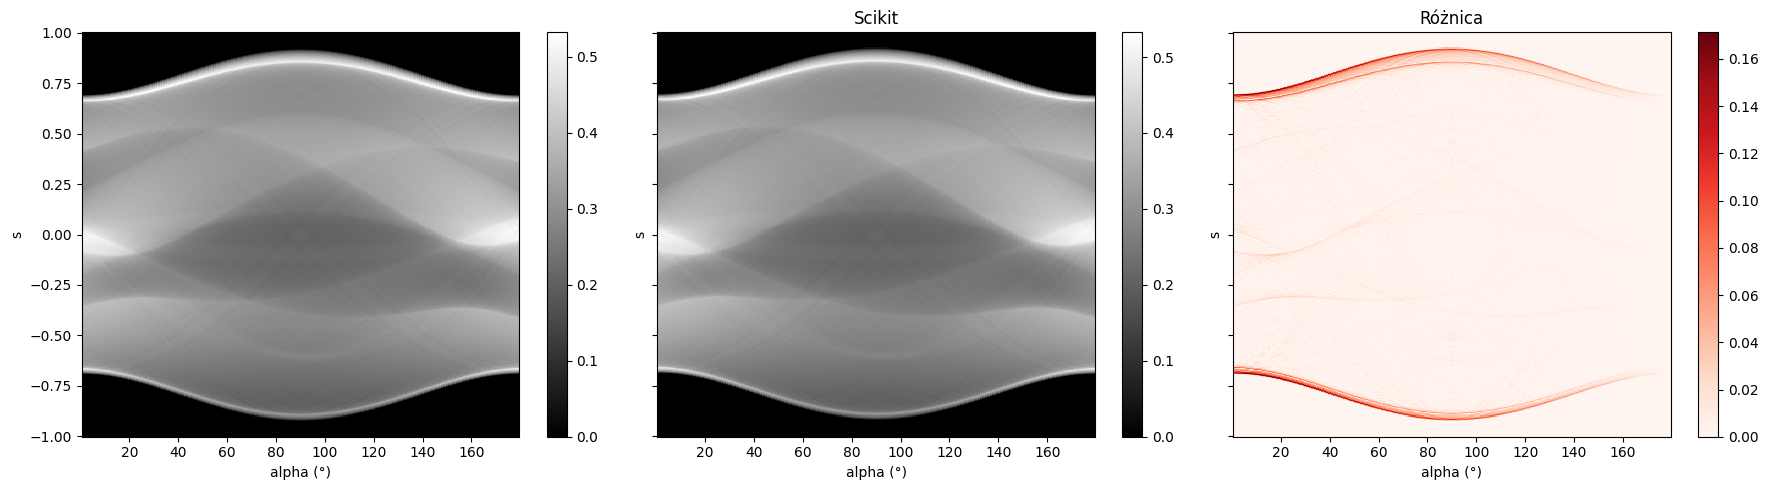

Maksymalna różnica: 0.17
Średnia różnica: 0.0043


In [111]:
from skimage.transform import radon

skimage_sinogram = radon(phantom_org, theta=alphas) * dS
skimage_sinogram = np.flip(skimage_sinogram, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

manual_im = axes[0].pcolormesh(alphas, esses, projections, shading='auto', cmap='gray')
axes[0].set_xlabel('alpha (°)')
axes[0].set_ylabel('s')
fig.colorbar(manual_im, ax=axes[0])

scikit_im = axes[1].pcolormesh(alphas, esses, skimage_sinogram, shading='auto', cmap='gray')
axes[1].set_title("Scikit")
axes[1].set_xlabel('alpha (°)')
axes[1].set_ylabel('s')
fig.colorbar(scikit_im, ax=axes[1])

difference = np.abs(projections - skimage_sinogram)
im = axes[2].pcolormesh(alphas, esses, difference, shading='auto', cmap='Reds')
axes[2].set_title('Różnica')
axes[2].set_xlabel('alpha (°)')
axes[2].set_ylabel('s')
fig.colorbar(im, ax=axes[2])


plt.tight_layout()
plt.show()

print(f"Maksymalna różnica: {np.max(difference):.2f}")
print(f"Średnia różnica: {np.mean(difference):.4f}")

### Odwrotna transformata Radona

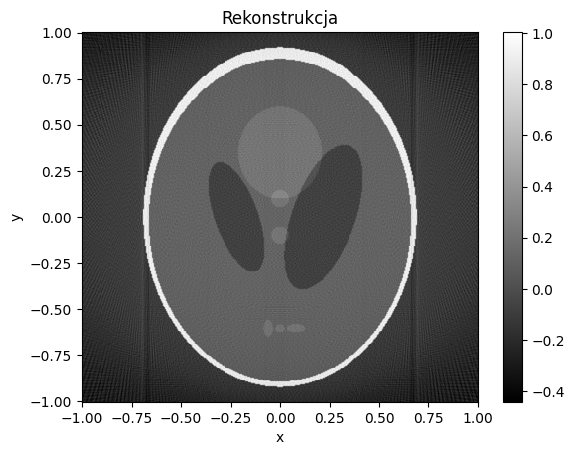

In [112]:
from scipy.fft import fft, ifft
from scipy.interpolate import RectBivariateSpline

dAlpha_rad = dAlpha * np.pi / 180

P = fft(projections, axis=0)
ramp = np.fft.fftfreq(P.shape[0], d=dS)

integrand = P * np.abs(ramp)[:, np.newaxis]
p_p = np.real(ifft(integrand, axis=0))

p_p_interp = RectBivariateSpline(esses, alphas, p_p)

def get_fBP(x, y):
    angles_rad = alphas * np.pi / 180
    s_vals = x * np.cos(angles_rad) + y * np.sin(angles_rad)
    vals = p_p_interp(s_vals, alphas, grid=False)
    return vals.sum() * dAlpha_rad

X, Y = np.meshgrid(esses, esses)
reco_im = np.vectorize(get_fBP)(X, Y)

plt.pcolormesh(esses, esses, reco_im, shading='auto', cmap='gray')
plt.colorbar()
plt.title('Rekonstrukcja')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

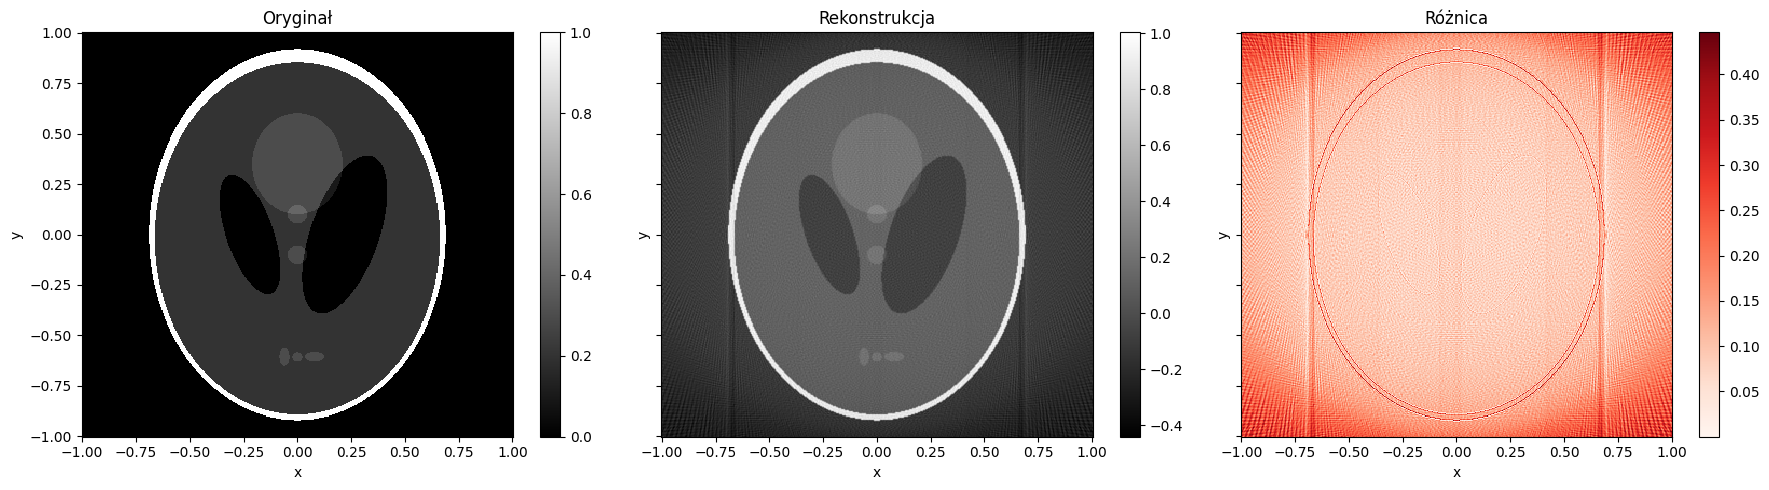

Maksymalna różnica: 0.45
Średnia różnica: 0.12


In [113]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Original Phantom
phantom_org_flip = np.flip(phantom_org, axis=0)
phantom_org_flip = np.flip(phantom_org_flip, axis=1)
org_im = axes[0].pcolormesh(esses, esses, phantom_org_flip, shading='auto', cmap='gray')
axes[0].set_title('Oryginał')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
fig.colorbar(org_im, ax=axes[0])

# Reconstructed Phantom
reco_ax = axes[1].pcolormesh(esses, esses, reco_im, shading='auto', cmap='gray')
axes[1].set_title('Rekonstrukcja')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
fig.colorbar(reco_ax, ax=axes[1])

# Difference
difference_image = np.abs(phantom_org_flip - reco_im)
im = axes[2].pcolormesh(esses, esses, difference_image, shading='auto', cmap='Reds')
axes[2].set_title('Różnica')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
fig.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"Maksymalna różnica: {np.max(difference_image):.2f}")
print(f"Średnia różnica: {np.mean(difference_image):.2f}")

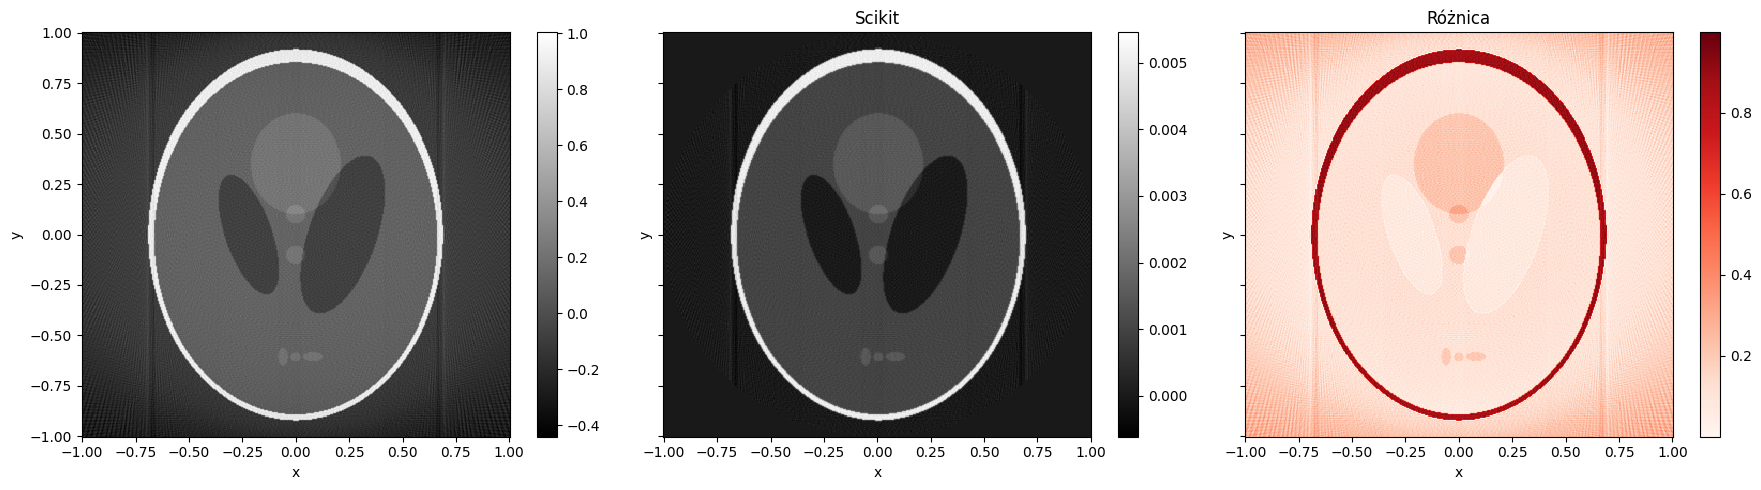

Maksymalna różnica: 1.00
Średnia różnica: 0.17


In [114]:
from skimage.transform import iradon

# Perform inverse Radon transform using scikit-image
skimage_reconstruction = iradon(skimage_sinogram, theta=alphas)
skimage_reconstruction = np.flip(skimage_reconstruction, axis=0)

# Compare with the manually calculated reconstruction
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Manually calculated reconstruction
manual_reco_im = axes[0].pcolormesh(esses, esses, reco_im, shading='auto', cmap='gray')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
fig.colorbar(manual_reco_im, ax=axes[0])

# Scikit-image reconstruction
skimage_reco_im = axes[1].pcolormesh(esses, esses, skimage_reconstruction, shading='auto', cmap='gray')
axes[1].set_title("Scikit")
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
fig.colorbar(skimage_reco_im, ax=axes[1])


# Difference
difference_image_skimage = np.abs(reco_im - skimage_reconstruction)
im = axes[2].pcolormesh(esses, esses, difference_image_skimage, shading='auto', cmap='Reds')
axes[2].set_title('Różnica')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
fig.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"Maksymalna różnica: {np.max(difference_image_skimage):.2f}")
print(f"Średnia różnica: {np.mean(difference_image_skimage):.2f}")